<p align="center">
    <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780081002858000055-f05-13-9780081002858.jpg" width="220" height="240" />

</p>

# Exploratory Data Analysis - Rod Pump Optimization

## Inventors Program Energy - NSC 325

#### Written by: Nicholas Khami, Nashra Ali, Vishrank


### Setup

#### Import Libraries

In [1]:
import glob
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#### Import Data

View The Head and dataframe properties. We are doing this primarily to get a rough idea of the data.

In [2]:
rpdf = pd.read_csv("../UT_RodPump_Dataset/rodpump_failure.csv")
rpdf.head()

,roduid,UWI,NODEID,IDWELL,tbguid,lifetime_start,lifetime_end,IDRECJOBPULL,REPORTTO,FAILSTART,...,overall_max_sideload,shallow_max_sideload,max_unguided_sideload,DESANDDEGAS_TYP,CHROME_LENGTH,ENDURALLOY_LENGTH,POLY_LENGTH,NIPPLE_SET_DEPTH,pump_bore,gasanchor_od
0,GB27GKBE51029074693667,175-58-0111,box-child-doctor,GPVO63973435661154,GB55QFGB46756147811400,2014-05-02 00:00:00.000,2019-01-04 10:00:00.000,FGNB86581338411987,Tubing,2018-12-11 00:00:00.000,...,NaN,NaN,NaN,UNKNOWN,0.0,0.00,0.0,10024.8,1.5,NaN
1,GB53OEVX46438297645035,333-68-3523,outside-worry,ZAYT33358197650329,GB29QCCC14341267287129,2018-01-28 14:00:00.000,2019-05-17 12:00:00.000,XRYU81281518151403,Tubing,2019-04-01 00:00:00.000,...,179.44,179.44,179.44,Miller LLC,0.0,0.00,0.0,10235.6,1.5,3.5
2,GB95BPWW35640301552066,165-51-5897,near-learn-simply,FNVL11432909873086,GB02DJAW44801752494129,2011-09-14 00:00:00.000,2012-08-20 00:00:00.000,PLPR44121073149707,Sucker Rod Pump,2012-08-01 00:00:00.000,...,105.76,105.76,105.76,Miller LLC,0.0,0.00,0.0,10401.9,1.5,NaN
3,GB79UEDN31454825972680,543-56-3494,sea-improve-place,JOKL33317998159514,GB84GHPH97287631470412,2016-01-12 09:00:00.000,2017-03-16 16:30:00.000,MYCF04792093856141,Sucker Rod Pump,2017-01-19 00:00:00.000,...,98.18,47.96,98.18,Miller LLC,0.0,0.00,0.0,9557.7,1.75,4.5
4,GB20XCTM13691331349509,391-37-2039,personal-candidate,XOSU92041716672870,GB08VYTX61977431827206,2018-06-14 13:00:00.000,2020-04-15 17:37:11.338,WJDB83445325478746,NaN,NaN,...,266.68,266.68,170.99,Miller LLC,0.0,129.39,0.0,9681.7,1.75,NaN


### Basic Data Cleanup Steps 

* As part of our data analysis, we thought it would be important to see what our numeric database statistics look like when we remove NaN and zero values. 
* For the non-numeric columns, we wanted to see whether or not we could simply any of the object/bool columns

#### Remove rows with no failure

In [3]:
rpdf = rpdf.dropna(subset=['FAILSTART'], axis=0)

#### Remove dashes from UWI 

In [4]:
rpdf['UWI'] = rpdf['UWI'].replace('-', '', regex=True).astype(int)

#### Convert DateTime Objects

In [5]:
rpdf['lifetime_start'] = pd.to_datetime(rpdf['lifetime_start'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_start'] = rpdf['lifetime_start'].astype(np.int64)

rpdf['lifetime_end'] = pd.to_datetime(rpdf['lifetime_end'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_end'] = rpdf['lifetime_end'].astype(np.int64)

rpdf['FAILSTART'] = pd.to_datetime(rpdf['FAILSTART'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['FAILSTART'] = rpdf['FAILSTART'].astype(np.int64)

#### Replace other values from pump_bore feature

In [6]:
rpdf['pump_bore'].replace(to_replace="Other", value=0, inplace=True)
rpdf['pump_bore'] = rpdf['pump_bore'].astype(float)

#### Drop Irrelevant Features 

In [7]:
rpdf.drop(['GrossStrokeLength', 'YesterdaysAverageSPM', 'shallow_max_sideload', 'max_unguided_sideload', 'CHROME_LENGTH', 'ENDURALLOY_LENGTH', 'POLY_LENGTH', 'gasanchor_od', 'chemgroup3_all', 'REPORTTO'], axis=1, inplace=True)

#### LabelEncode Necessary Features

In [8]:
labelencoder = LabelEncoder()
rpdf_cleaned = rpdf.copy()

rpdf_cleaned['roduid'] = labelencoder.fit_transform(rpdf_cleaned['roduid'])
rpdf_cleaned['IDWELL'] = labelencoder.fit_transform(rpdf_cleaned['IDWELL'])
rpdf_cleaned['tbguid'] = labelencoder.fit_transform(rpdf_cleaned['tbguid'])
rpdf_cleaned['IDRECJOBPULL'] = labelencoder.fit_transform(rpdf_cleaned['IDRECJOBPULL'])
rpdf_cleaned['FAILURETYPE'] = labelencoder.fit_transform(rpdf_cleaned['FAILURETYPE'])
rpdf_cleaned['bha_configuration'] = labelencoder.fit_transform(rpdf_cleaned['bha_configuration'])
rpdf_cleaned['wellbore_category'] = labelencoder.fit_transform(rpdf_cleaned['wellbore_category'])
rpdf_cleaned['manual_scale'] = labelencoder.fit_transform(rpdf_cleaned['manual_scale'])
rpdf_cleaned['packer_vs_tac'] = labelencoder.fit_transform(rpdf_cleaned['packer_vs_tac'])
rpdf_cleaned['rod_has_guides'] = labelencoder.fit_transform(rpdf_cleaned['rod_has_guides'])
rpdf_cleaned['rod_make'] = labelencoder.fit_transform(rpdf_cleaned['rod_make'])
rpdf_cleaned['rod_apigrade'] = labelencoder.fit_transform(rpdf_cleaned['rod_apigrade'])
rpdf_cleaned['DESANDDEGAS_TYP'] = labelencoder.fit_transform(rpdf_cleaned['DESANDDEGAS_TYP'])
rpdf_cleaned['rod_sinker_type'] = labelencoder.fit_transform(rpdf_cleaned['rod_sinker_type'])
rpdf_cleaned['NODEID'] = labelencoder.fit_transform(rpdf_cleaned['NODEID'])

#### Feature Selection Based On Presence 

We wanted to get rid of any features that had less than 1660 rows of non-null values. 1660 was chosen based on looking at the the features we thought we would be heuristically valuable. 

Removed Features: ```['H2S_CONCENTRATION', 'GrossStrokeLength', 'chemgroup1_any', 'chemgroup1_all', 'chemgroup2_any', 'chemgroup2_all', 'chemgroup3_any', 'chemgroup3_all', 'rod_has_guides', 'CHROME_LENGTH', 'ENDURALLOY_LENGTH', 'POLY_LENGTH', 'gasanchor_od']```

In [9]:
# Alternative Setup For Flexible Removal 
   # perc = 30.0 # Like N %
   # min_count =  int(((100-perc)/100)*rpdf.shape[0] + 1)
# Chosen Value based on uniques for heuristically useful features 
min_count = 1
rpdf_cleaned = rpdf_cleaned.dropna(axis=1, thresh=min_count)

removed_columns = []
for column in rpdf.columns: 
   if(column not in rpdf_cleaned.columns): 
      removed_columns.append(column)

print(removed_columns)

[]


#### Remove Rows with 20 percent or more NaN values

In [10]:
rpdf_cleaned = rpdf_cleaned.dropna(axis=0, thresh=8)
print((str)(rpdf.shape[0] - rpdf_cleaned.shape[0]) + ' rows were removed out of ' + (str)(rpdf.shape[0]))
rpdf_cleaned.shape

0 rows were removed out of 1725


(1725, 45)

#### Remove Outliers

* At this step we chose to drop the following features: ```['PrimarySetpoint', 'AVG_WATERSG']``` because they consisted of only outliers 
* We think that this requires more detailed tuning by changing the multiplication factor for iqr based on the specific variance of each feature

In [11]:
# def remove_outlier(df_in, col_name):
#     # print(column)
#     q1 = df_in[col_name].quantile(0.25)
#     q3 = df_in[col_name].quantile(0.75)
#     iqr = q3-q1 #Interquartile range
#     fence_low  = q1-7*iqr
#     fence_high = q3+7*iqr
#     df_out = df_in[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
#     # print(df_out.shape)
#     return df_out

# rpdf_cleaned.drop(columns=['PrimarySetpoint', 'AVG_WATERSG'], inplace=True)

# for column in rpdf_cleaned.columns: 
#    if(rpdf_cleaned.dtypes[column] in [np.int64, np.float64]): 
#         rpdf_cleaned = remove_outlier(rpdf_cleaned, column)
      
# rpdf_cleaned.shape

### Get High Level DataFrame Information 

Print the overall shape of the data to evaluate the counts later on. 

In [12]:
rpdf_cleaned.shape

(1725, 45)

Print all of the columns so that we can get a rough idea for what features we will have to train on. Looking at the list, we have a rough idea that based on FAILURETYPE, there will be different features that predict the lifespan of the well. 

In [13]:
rpdf_cleaned.columns

Index(['roduid', 'UWI', 'NODEID', 'IDWELL', 'tbguid', 'lifetime_start',
       'lifetime_end', 'IDRECJOBPULL', 'FAILSTART', 'FAILURETYPE',
       'H2S_CONCENTRATION', 'PrimarySetpoint', 'SecondarySetpoint',
       'StrokeLength', 'Fillage', 'bha_configuration', 'chemgroup1_any',
       'chemgroup1_all', 'chemgroup2_any', 'chemgroup2_all', 'chemgroup3_any',
       'max_unguided_dls', 'dls_high_in_hole', 'gas_anchor_length',
       'MAX_INCLINATION', 'wellbore_category', 'manual_scale', 'packer_vs_tac',
       'AVG_PRESS_FLOWLINE', 'AVG_PRESSURE_TUBING', 'AVG_PRESSURE_CASING',
       'AVG_DIFFERENTIAL_PRESSURE', 'AVG_OIL_VOLUME', 'AVG_WATER_VOLUME',
       'AVG_LIQUID_VOLUME', 'AVG_WATERSG', 'rod_sinker_type', 'rod_has_guides',
       'rod_make', 'rod_apigrade', 'ROUTE', 'overall_max_sideload',
       'DESANDDEGAS_TYP', 'NIPPLE_SET_DEPTH', 'pump_bore'],
      dtype='object')

#### Analysis of Numeric DataFrame features

Here, we use describe() to get the count, mean, standard deviation, min, and max for numeric variables. The code that follows is simply formatting the output. 

Heuristically, there are a few features that we think will be promising when training our model: AVG_LIQUID_VOLUME (oil and water), overall_max_sideload, shallow_max_sideload, max_unguided_sideload, NIPPLE_SET_DEPTH, and then all of the average pressures. There were several features such as StrokeLength and Fillage that we thought may be good predictors of failure, but they lacked differentiation throughout the dataframe. 

We think that the features listed are promising because they have differentiation across their quartiles and strong representation throughout the dataframe. Additionally, we hypothesize that they will reflect overall stress on the Rod Pump. 

In [14]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', 55)
rpdf_numeric_summary = rpdf_cleaned.describe()
print(rpdf_numeric_summary.shape)
rpdf_numeric_summary

(8, 45)


,roduid,UWI,NODEID,IDWELL,tbguid,lifetime_start,lifetime_end,IDRECJOBPULL,FAILSTART,FAILURETYPE,H2S_CONCENTRATION,PrimarySetpoint,SecondarySetpoint,StrokeLength,Fillage,bha_configuration,chemgroup1_any,chemgroup1_all,chemgroup2_any,chemgroup2_all,chemgroup3_any,max_unguided_dls,dls_high_in_hole,gas_anchor_length,MAX_INCLINATION,wellbore_category,manual_scale,packer_vs_tac,AVG_PRESS_FLOWLINE,AVG_PRESSURE_TUBING,AVG_PRESSURE_CASING,AVG_DIFFERENTIAL_PRESSURE,AVG_OIL_VOLUME,AVG_WATER_VOLUME,AVG_LIQUID_VOLUME,AVG_WATERSG,rod_sinker_type,rod_has_guides,rod_make,rod_apigrade,ROUTE,overall_max_sideload,DESANDDEGAS_TYP,NIPPLE_SET_DEPTH,pump_bore
count,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1233,1725,1725,1725,1725,1725,1725,1697,1689,1724,1693,1725,1725,1725,949,1682,1686,1685,1709,1709,1709,1154,1725,1725,1725,1725,1725,1188,1725,1713,1725
mean,862,459241906,283,290,658,1425118538260867328,1464088169016084480,844,1458605914539130624,1,3,74,58,148,83,3,0,0,0,0,0,3,3,18,5,2,0,1,57,83,117,35,86,42,128,1,1,0,3,3,883,196,2,9866,2
std,498,247526596,165,168,383,102453440551570176,100767322746880992,488,99716157756249424,1,52,7,13,15,26,1,0,0,0,0,0,6,6,7,5,1,0,1,18,57,92,135,56,48,94,0,1,0,1,1,12,132,1,626,0
min,0,5649456,0,0,0,1093392000000000000,1133136000000000000,0,1133136000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-987,0,0,0,1,0,0,0,0,867,0,0,4066,0
25%,431,261228393,140,139,332,1380240000000000000,1428537600000000000,423,1421625600000000000,1,0,75,60,144,78,1,0,0,0,0,0,1,1,17,2,1,0,0,50,62,68,0,47,15,70,1,1,0,2,1,873,106,1,9641,2
50%,862,458294834,279,295,650,1450224000000000000,1491645960000000000,843,1483447800000000000,2,0,75,60,144,88,3,0,0,0,0,0,2,2,19,2,3,0,0,58,77,99,19,77,32,114,1,1,0,2,4,882,175,1,9941,2
75%,1293,669700374,420,435,995,1499509800000000000,1536408000000000000,1266,1532217600000000000,2,0,75,60,144,95,3,1,0,1,0,0,3,3,21,6,3,0,1,66,98,145,59,113,53,165,1,1,1,3,4,886,257,4,10228,2
max,1724,899590664,571,571,1317,1583431200000000000,1586972231337999872,1691,1585872000000000000,3,1963,90,100,216,655,5,1,1,1,1,1,92,92,45,53,4,1,5,248,1020,1108,4424,516,1067,1583,1,3,1,5,5,905,1351,5,12026,2


#### Analysis of Non-Numeric DataFrame features

* During data cleanup, we will need to make lifetime_start and lifetime_end into one feature called lifetime to have better model training 
* We anticipate that FAILSTART will also be incredibly important and must be turned into an int/float that is easier to train on
* We anticipate that FAILURETYPE will be incredibly important in terms of predicting FAILSTART. If we find that FAILURETYPE has strong correlation to FAILSTART then it may be better to predict FAILURETYPE than FAILSTART

In [15]:
# rpdf_strobj_summary = rpdf_cleaned.describe(include=['bool', 'object'])
# print(rpdf_strobj_summary.shape)
# rpdf_strobj_summary

### Visualize Data

#### Calculate Correlation Matrix

* Note: It would be great to encode the Strings for FailureType with LabelEncoder from sklearn --> preprocessing 
* Note: It would also be great to numerify the dates so that they would also appear on the heatmap

<AxesSubplot:>

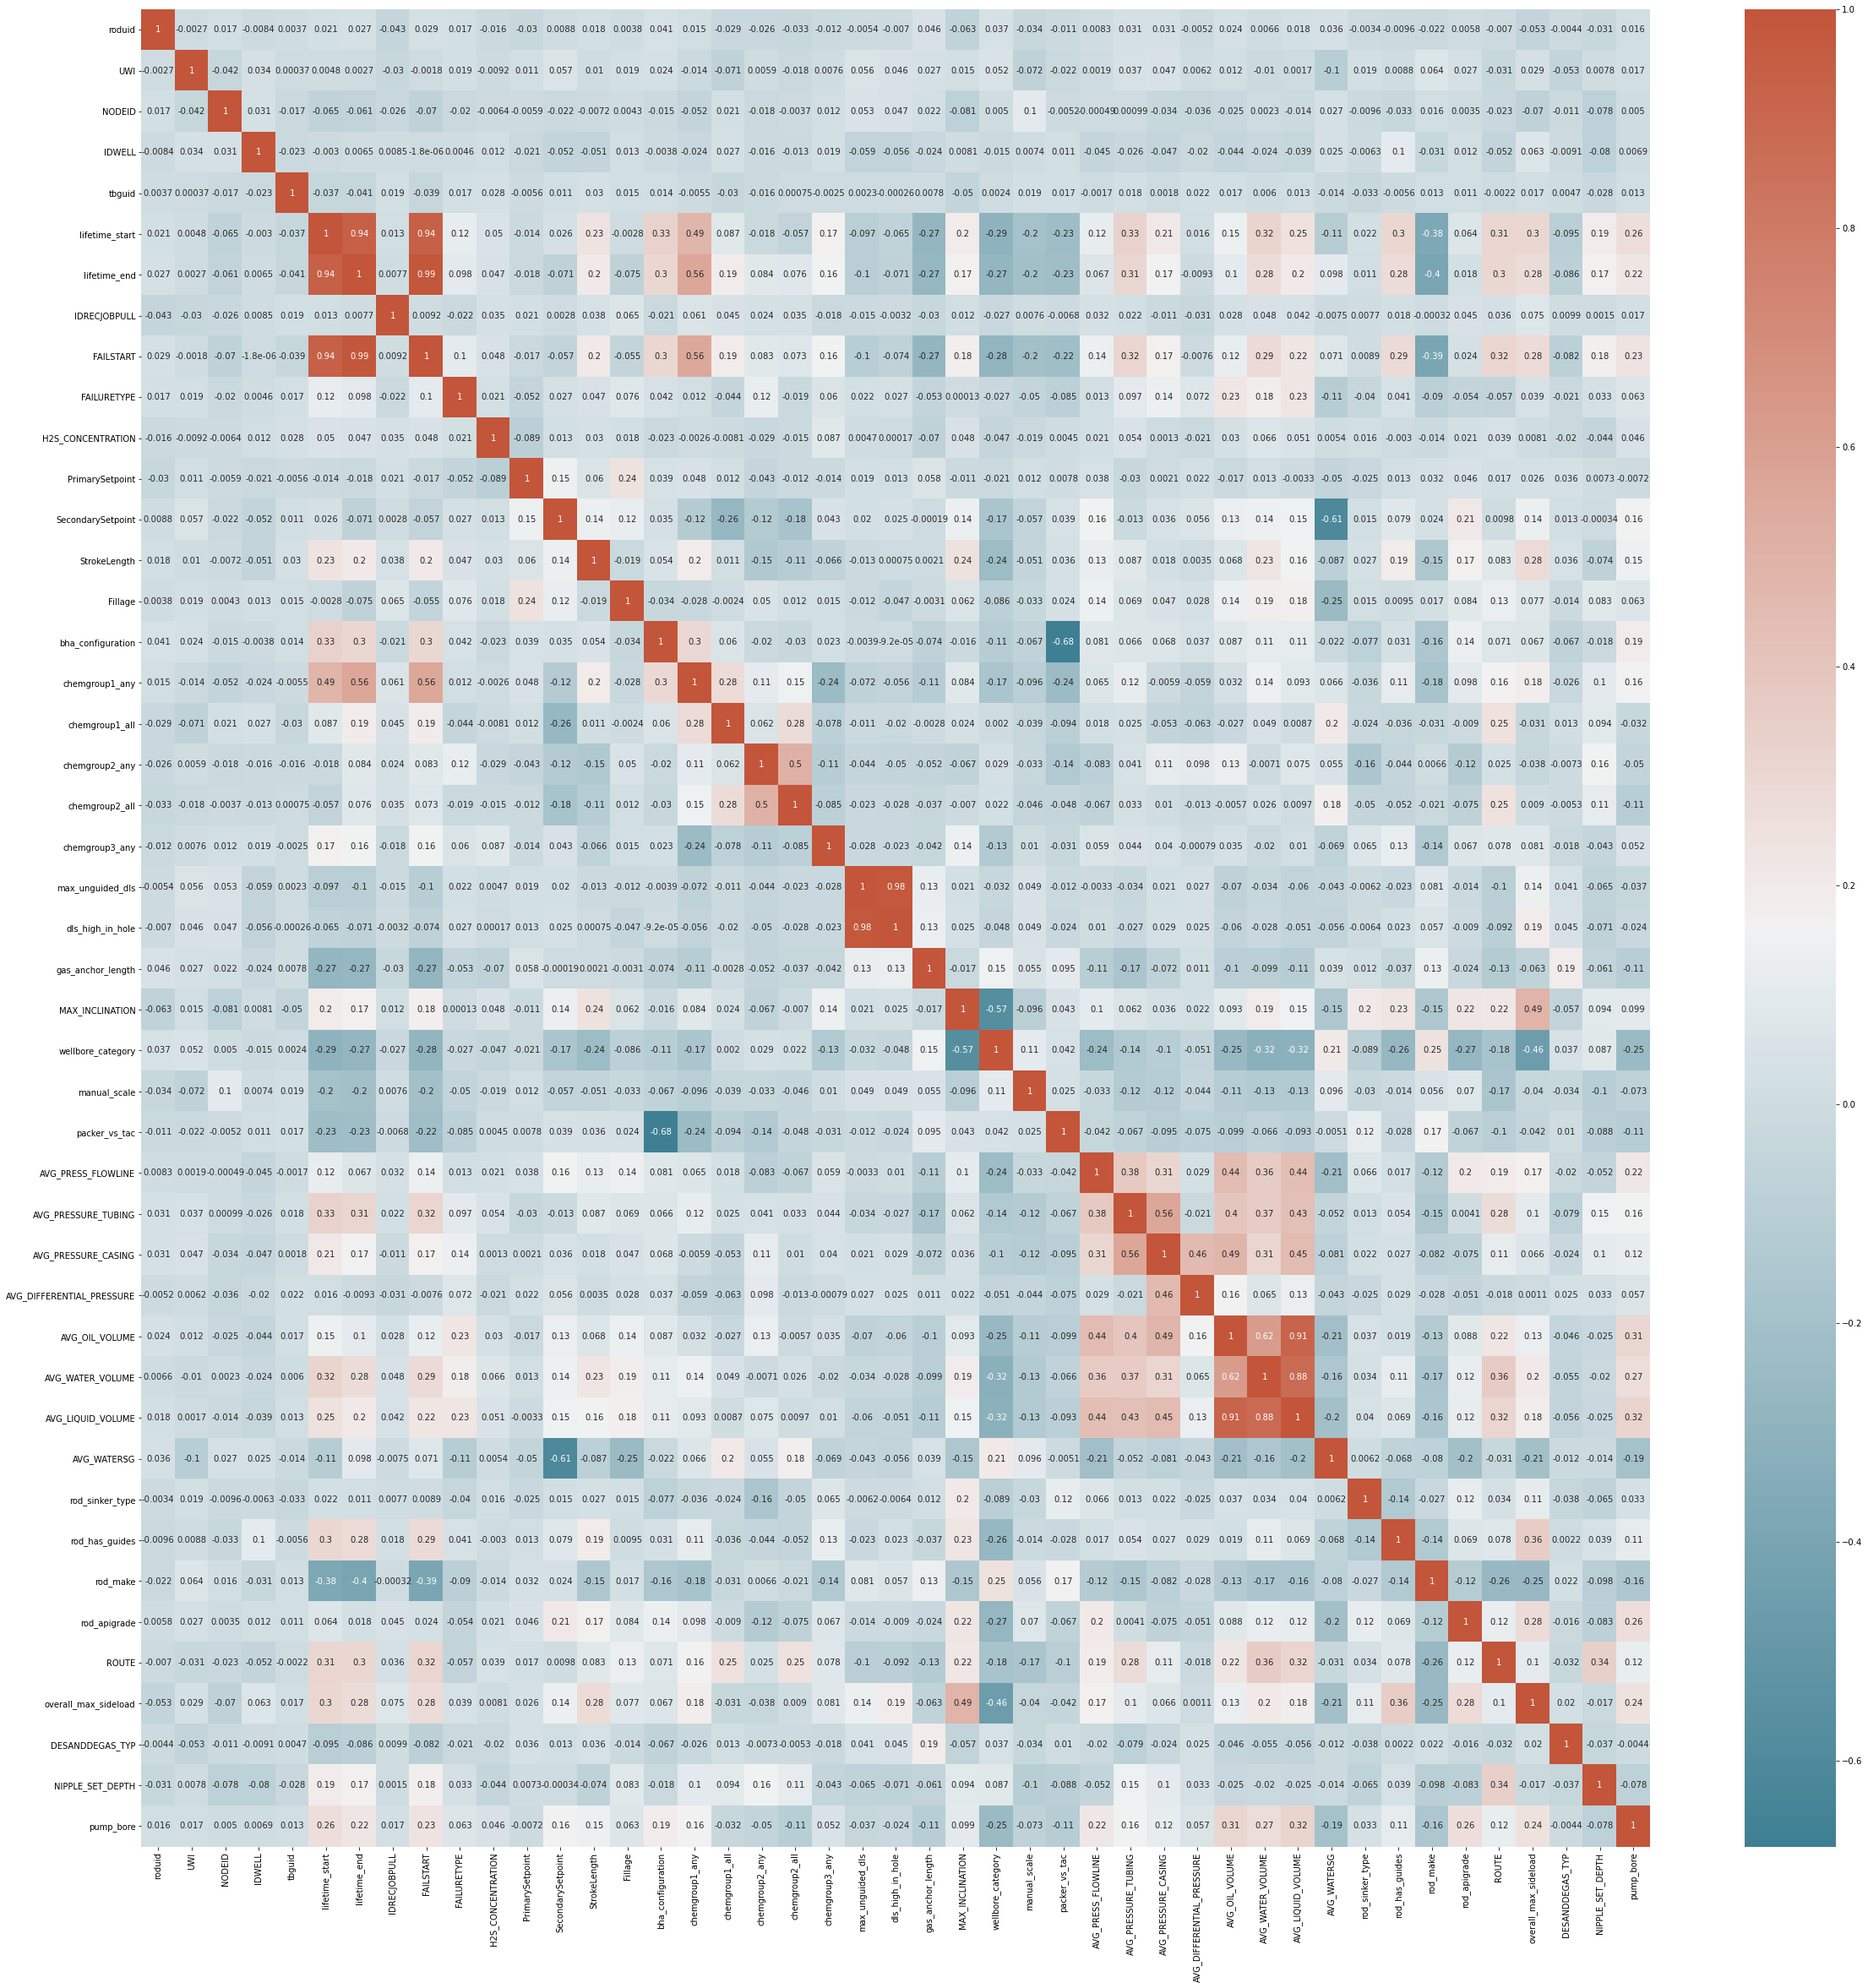

In [16]:
corr = rpdf_cleaned.corr()# plot the heatmap
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))